# Практика к занятию 3. Градиентный спуск и его модификации.

**Что попробуем:**
- реализовать разные модификации градиентного спуска,
- сравнить их по времени работы и метрикам,
- добавить регуляризацию.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# данные, предобработка, моделирование
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor

# метрики
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_log_error,
    max_error,
    r2_score
)

np.random.seed(28)

## 0. Загрузка данных и вспомогательные функции.

In [ ]:
# Загрузим набор данных California Housing
data = fetch_california_housing()
X, y = data.data, data.target
feature_names = data.feature_names
print(X.shape)
print(feature_names)
print(type(X), type(y))

(20640, 8)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
df = pd.DataFrame(X, columns=feature_names)
df["target"] = y
print(df.shape)
df.head()

(20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [ ]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


<Axes: >

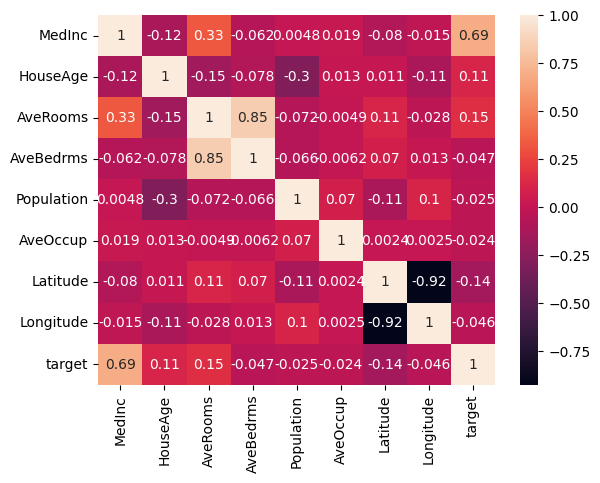

In [ ]:
sns.heatmap(df.corr(), annot=True)

In [ ]:
X = df.drop(["target", "Longitude", "AveBedrms"], axis=1)

In [ ]:
# Разделим на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизируем данные
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Добавим признак-смещение (bias)
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]

In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
def predict(X, weights):
    """
    Расчёт предсказания модели
    """
    return X @ weights

def mse_loss(y_true, y_pred):
    """
    Расчёт значения функции ошибки MSE
    """
    return np.mean((y_true - y_pred) ** 2)

In [ ]:
def plot_history(losses):
    """
    Визуализация графика сходимости
    (значение loss в зависимости от номера итерации)
    """
    plt.plot(losses)
    plt.xlabel("Iteration")
    plt.ylabel("MSE Loss")
    plt.title("График сходимости градиентного спуска")
    plt.grid(True)
    plt.show()

In [ ]:
def regression_metrics(y_true, y_pred):
    """
    Вычисляет метрики качества линейной регрессии.

    Parameters
    ----------
    y_true : array-like
        Реальные значения (таргет).
    y_pred : array-like
        Предсказанные значения.

    Returns
    -------
    dict
        Словарь с метриками: MSE, RMSE, MAE, MAPE, MSLE, MaxError, R².
    """

    # MSE
    mse = mean_squared_error(y_true, y_pred)

    # RMSE
    rmse = np.sqrt(mse)

    # MAE
    mae = mean_absolute_error(y_true, y_pred)

    # MAPE (может вернуть inf, если y_true содержит нули)
    try:
        mape = mean_absolute_percentage_error(y_true, y_pred)
    except:
        mape = np.nan

    # MSLE (работает только если y_true, y_pred >= 0)
    try:
        msle = mean_squared_log_error(y_true, y_pred)
    except:
        msle = np.nan

    # MaxError
    max_err = max_error(y_true, y_pred)

    # R^2
    r2 = r2_score(y_true, y_pred)

    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "MSLE": msle,
        "MaxError": max_err,
        "R²": r2
    }

## 1. Классический градиентный спуск.

*Базовая формула:*

$w_{k+1} = w_k - \eta \cdot \nabla_w L(w_k)$

In [ ]:
def gradient_descent(
    X, y, lr=0.1, n_iter=1000, calc_loss=True, print_loss=True
):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features) # начальное приближение
    losses = []

    for i in range(n_iter):
        # предсказание
        y_pred = predict(X, weights)

        # градиент
        error = y_pred - y
        grad = (2 / n_samples) * X.T @ error

        # обновление весов
        weights = weights - lr * grad

        # расчёт и сохранение ошибки
        if calc_loss:
            loss = mse_loss(y, y_pred)
            losses.append(loss)

            # промежуточные выводы на экран
            if print_loss and i % 10 == 0:
                print(f"Iteration {i}: MSE = {loss:.4f}")

    return weights, losses

In [ ]:
np.sqrt(0.6386) / (y.max() - y.min())

np.float64(0.16476726301340652)

In [ ]:
np.sqrt(0.6386)

np.float64(0.7991245209602819)

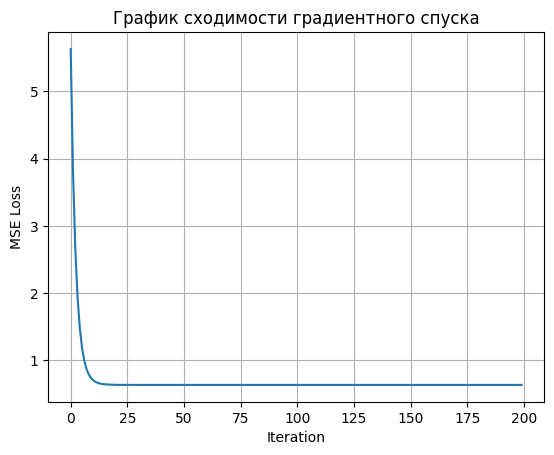

[ 2.07194694  0.83610282  0.22105212 -0.05036069  0.02119718 -0.04873706
 -0.09443353]


In [ ]:
weights, losses = gradient_descent(
    X_train, y_train, lr=0.1, n_iter=200, calc_loss=True, print_loss=False
)
plot_history(losses) # визуализация истории обучения
print(weights) # веса

# считаем предсказания на train и test
p_gd_train = predict(X_train, weights)
p_gd_test = predict(X_test, weights)

In [ ]:
# классический GD
display(regression_metrics(y_train, p_gd_train))
print()
display(regression_metrics(y_test, p_gd_test))

{'MSE': 0.6385422259115964,
 'RMSE': np.float64(0.7990883717784888),
 'MAE': 0.5908335989331474,
 'MAPE': 0.3542166608296112,
 'MSLE': 0.06123908421291491,
 'MaxError': np.float64(5.665540111672882),
 'R²': 0.5223274734132326}

{'MSE': 0.6492877827022964,
 'RMSE': np.float64(0.8057839553517409),
 'MAE': 0.5940374244098705,
 'MAPE': 0.3598880760656618,
 'MSLE': 0.061947032615812705,
 'MaxError': np.float64(4.367511754300323),
 'R²': 0.5045151601648029}

## 2. Стохастический градиентный спуск.

*Базовая формула:*

$w_{k+1} = w_k - \eta \cdot \nabla_w L\big(w_k; x_i, y_i\big)$

In [ ]:
def stochastic_gradient_descent(
    X, y, lr=0.1, n_iter=1000, calc_loss=True, print_loss=False
):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    losses = []

    for i in range(n_iter):
        # случайный индекс примера
        idx = np.random.randint(0, n_samples)
        x_i = X[idx]
        y_i = y[idx]

        # предсказание
        y_pred = x_i @ weights

        # градиент (по одному примеру)
        error = y_pred - y_i
        grad = 2 * x_i * error

        # обновление весов
        weights -= lr * grad

        # для отслеживания динамики считаем полный лосс
        if calc_loss:
            y_full_pred = predict(X, weights)
            loss = mse_loss(y, y_full_pred)
            losses.append(loss)

            # промежуточные выводы на экран
            if print_loss and i % 10 == 0:
                print(f"Iteration {i}: MSE = {loss:.4f}")

    return weights, losses

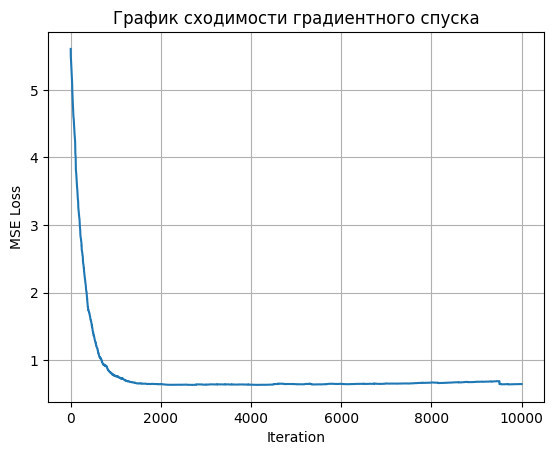

[ 2.06872895e+00  8.67280927e-01  2.17053264e-01 -1.37043425e-01
  1.35762333e-03 -1.20442643e-01 -1.17186391e-01]


In [ ]:
weights, losses = stochastic_gradient_descent(
    X_train, y_train, lr=0.001, n_iter=10000, calc_loss=True, print_loss=False
)
plot_history(losses) # визуализация истории обучения
print(weights) # веса

# считаем предсказания на train и test
p_sgd_train = predict(X_train, weights)
p_sgd_test = predict(X_test, weights)

In [ ]:
# стохастический GD
display(regression_metrics(y_train, p_sgd_train))
print()
display(regression_metrics(y_test, p_sgd_test))

{'MSE': 0.7086735151187152,
 'RMSE': np.float64(0.8418274853666369),
 'MAE': 0.6011441673014345,
 'MAPE': 0.3241470554639857,
 'MSLE': nan,
 'MaxError': np.float64(4.82758709279562),
 'R²': 0.4698645527966254}

{'MSE': 0.7139090777372643,
 'RMSE': np.float64(0.8449314041608729),
 'MAE': 0.5988700254264129,
 'MAPE': 0.3274851504281438,
 'MSLE': 0.06428858396252174,
 'MaxError': np.float64(4.285808586459046),
 'R²': 0.455201322952152}

In [ ]:
y_test.min(), y_test.max()

(np.float64(0.14999), np.float64(5.00001))

In [ ]:
0.884/(5.00001 - 0.14999)

0.18226728961942426

## 3. Мини-батчевый градиентный спуск.

*Базовая формула:*

$w_{k+1} = w_k - \eta \cdot \frac{1}{m} \sum_{j \in B} \nabla_w L\big(w_k; x_j, y_j\big)$

In [ ]:
def minibatch_gradient_descent(
    X, y, lr=0.1, n_iter=1000,
    calc_loss=True, print_loss=False, batch_size=16
):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    losses = []

    for i in range(n_iter):
        # случайный мини-батч
        indices = np.random.choice(n_samples, batch_size, replace=False)
        X_batch = X[indices]
        y_batch = y[indices]

        # предсказание и градиент
        y_pred = X_batch @ weights
        error = y_pred - y_batch
        grad = (2 / batch_size) * X_batch.T @ error

        # обновление весов
        weights -= lr * grad

        # трекинг лосса по всему train
        if calc_loss:
            full_pred = predict(X, weights)
            loss = mse_loss(y, full_pred)
            losses.append(loss)

            # промежуточные выводы на экран
            if print_loss and i % 10 == 0:
                print(f"Iteration {i}: MSE = {loss:.4f}")

    return weights, losses

Iteration 0: MSE = 5.4909
Iteration 10: MSE = 4.2424
Iteration 20: MSE = 2.8900
Iteration 30: MSE = 2.1418
Iteration 40: MSE = 1.6216
Iteration 50: MSE = 1.3193
Iteration 60: MSE = 1.0786
Iteration 70: MSE = 0.9193
Iteration 80: MSE = 0.8214
Iteration 90: MSE = 0.7599


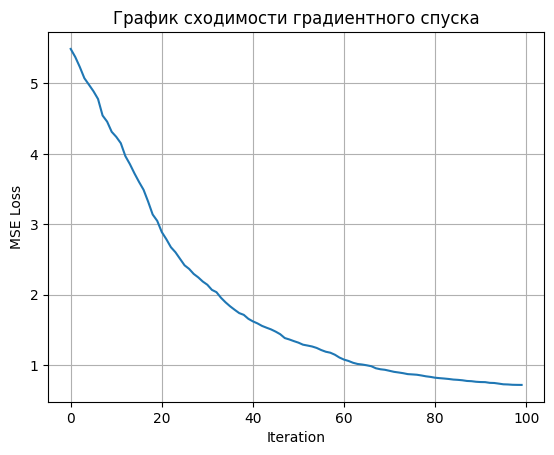

[ 1.8136469   0.73976378  0.17857717  0.0574826  -0.01210192 -0.04058673
 -0.12633126]


In [ ]:
weights, losses = minibatch_gradient_descent(
    X_train, y_train, lr=0.01, n_iter=100,
    calc_loss=True, print_loss=True, batch_size=16
)
plot_history(losses) # визуализация истории обучения
print(weights) # веса

# считаем предсказания на train и test
p_mb_gd_train = predict(X_train, weights)
p_mb_gd_test = predict(X_test, weights)

In [ ]:
# мини-батчевый GD
display(regression_metrics(y_train, p_mb_gd_train))
print()
display(regression_metrics(y_test, p_mb_gd_test))

{'MSE': 0.7189617290768512,
 'RMSE': np.float64(0.8479161096929644),
 'MAE': 0.5988258875821214,
 'MAPE': 0.3130667763756376,
 'MSLE': 0.06522766265074731,
 'MaxError': np.float64(5.15124170676112),
 'R²': 0.46216827687934814}

{'MSE': 0.7303072237151078,
 'RMSE': np.float64(0.8545801446997864),
 'MAE': 0.5980056137133254,
 'MAPE': 0.3154814527492227,
 'MSLE': 0.06610908099506377,
 'MaxError': np.float64(4.3576434346538875),
 'R²': 0.4426875610273395}

### GD vs SGD vs Mini-Batch

А зачем всё это нужно, если точность ниже?

Сравним время работы!

In [ ]:
%%timeit
gradient_descent(X_train, y_train, lr=0.01, n_iter=1000, calc_loss=False, print_loss=False)

410 ms ± 132 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
stochastic_gradient_descent(X_train, y_train, lr=0.01, n_iter=1000, calc_loss=False, print_loss=False)

36.6 ms ± 13.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
# зависит от размера батча + рандом тоже занимает время:(
minibatch_gradient_descent(X_train, y_train, lr=0.01, n_iter=1000, calc_loss=False, print_loss=False)

346 ms ± 81.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 4. AdaGrad

*Базовая формула:*

$g_k = \nabla_w L(w_k; x_i, y_i),$

$G_k = G_{k-1} + g_k \odot g_k$

$w_{k+1} = w_k - \frac{\eta}{\sqrt{G_k + \epsilon}} \odot g_k$

In [ ]:
def adagrad(
    X, y, lr=0.5, n_iter=1000, epsilon=1e-8, calc_loss=True, print_loss=False
):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    G = np.zeros(n_features)  # накопление квадратов градиентов
    losses = []

    for i in range(n_iter):
        # полная предсказательная ошибка
        y_pred = predict(X, weights)
        error = y_pred - y
        grad = (2 / n_samples) * X.T @ error

        # обновление накопленной суммы квадратов градиентов
        G += grad ** 2

        # масштабирование градиента
        adjusted_grad = grad / (np.sqrt(G) + epsilon)
        weights -= lr * adjusted_grad

        # лосс
        if calc_loss:
            loss = mse_loss(y, y_pred)
            losses.append(loss)

            # промежуточные выводы на экран
            if print_loss and i % 10 == 0:
                print(f"Iteration {i}: MSE = {loss:.4f}")

    return weights, losses

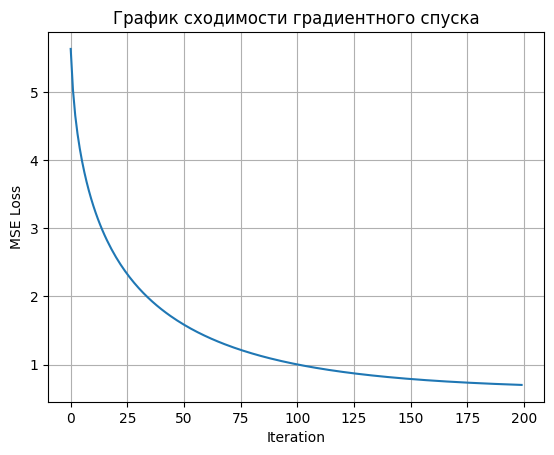

[ 1.8146469   0.83598003  0.22104398 -0.05031511  0.02119681 -0.04873375
 -0.0944492 ]


In [ ]:
weights, losses = adagrad(
    X_train, y_train, lr=0.1, n_iter=200
)

plot_history(losses) # визуализация истории обучения
print(weights) # веса

# считаем предсказания на train и test
p_ada_train = predict(X_train, weights)
p_ada_test = predict(X_test, weights)

In [ ]:
# AdaGrad
display(regression_metrics(y_train, p_ada_train))
print()
display(regression_metrics(y_test, p_ada_test))

{'MSE': 2.3319828785058045,
 'RMSE': np.float64(1.5270831275689627),
 'MAE': 1.2742858536393598,
 'MAPE': 0.6198647668083821,
 'MSLE': 0.34178866732484414,
 'MaxError': np.float64(5.295121189909829),
 'R²': -0.7444800176569193}

{'MSE': 2.3317764235184804,
 'RMSE': np.float64(1.527015528250607),
 'MAE': 1.2721791465796237,
 'MAPE': 0.6258504212361715,
 'MSLE': 0.34573204403457936,
 'MaxError': np.float64(5.236316534552465),
 'R²': -0.7794264708478036}

## 5. RMSProp

*Базовая формула:*

$g_k = \nabla_w L(w_k; x_i, y_i),$

$E[g^2]_k = \rho \, E[g^2]_{k-1} + (1 - \rho) \, (g_k \odot g_k),$

$w_{k+1} = w_k - \frac{\eta}{\sqrt{E[g^2]_k + \epsilon}} \odot g_k$

In [ ]:
def rmsprop(
    X, y, lr=0.01, n_iter=1000, beta=0.9, epsilon=1e-8,
    calc_loss=True, print_loss=False
):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    Eg = np.zeros(n_features)  # экспоненциальное среднее квадратов градиентов
    losses = []

    for i in range(n_iter):
        y_pred = predict(X, weights)
        error = y_pred - y
        grad = (2 / n_samples) * X.T @ error

        # обновляем экспоненциальное среднее квадратов градиентов
        Eg = beta * Eg + (1 - beta) * grad**2
        # масштабируем градиент (делим на корень из среднего квадрата)
        adjusted_grad = grad / (np.sqrt(Eg) + epsilon)
        # обновляем веса
        weights -= lr * adjusted_grad

        # лосс
        if calc_loss:
            loss = mse_loss(y, y_pred)
            losses.append(loss)

            # промежуточные выводы на экран
            if print_loss and i % 10 == 0:
                print(f"Iteration {i}: MSE = {loss:.4f}")

    return weights, losses

Iteration 0: MSE = 5.6297
Iteration 10: MSE = 4.6459
Iteration 20: MSE = 4.1333
Iteration 30: MSE = 3.7049
Iteration 40: MSE = 3.3226
Iteration 50: MSE = 2.9770
Iteration 60: MSE = 2.6647
Iteration 70: MSE = 2.3838
Iteration 80: MSE = 2.1320
Iteration 90: MSE = 1.9067
Iteration 100: MSE = 1.7047
Iteration 110: MSE = 1.5229
Iteration 120: MSE = 1.3595
Iteration 130: MSE = 1.2139
Iteration 140: MSE = 1.0861
Iteration 150: MSE = 0.9756
Iteration 160: MSE = 0.8822
Iteration 170: MSE = 0.8055
Iteration 180: MSE = 0.7449
Iteration 190: MSE = 0.6993
Iteration 200: MSE = 0.6678
Iteration 210: MSE = 0.6487
Iteration 220: MSE = 0.6393
Iteration 230: MSE = 0.6363
Iteration 240: MSE = 0.6359
Iteration 250: MSE = 0.6358
Iteration 260: MSE = 0.6358
Iteration 270: MSE = 0.6358
Iteration 280: MSE = 0.6358
Iteration 290: MSE = 0.6358
Iteration 300: MSE = 0.6358
Iteration 310: MSE = 0.6358
Iteration 320: MSE = 0.6358
Iteration 330: MSE = 0.6359
Iteration 340: MSE = 0.6358
Iteration 350: MSE = 0.6359
Ite

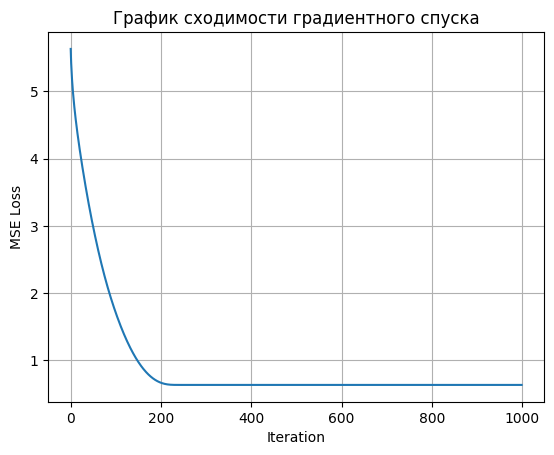

[ 2.07694693  0.83110283  0.22605211 -0.05536069  0.01619718 -0.05373705
 -0.08943354]


In [ ]:
weights, losses = rmsprop(
    X_train, y_train, lr=0.01, n_iter=1000,
    calc_loss=True, print_loss=True,
)

plot_history(losses) # визуализация истории обучения
print(weights) # веса

# считаем предсказания на train и test
p_rms_train = predict(X_train, weights)
p_rms_test = predict(X_test, weights)

In [ ]:
# RmsProp
display(regression_metrics(y_train, p_rms_train))
print()
display(regression_metrics(y_test, p_rms_test))

{'MSE': 0.6358660368614794,
 'RMSE': np.float64(0.7974120872306109),
 'MAE': 0.5950406915145289,
 'MAPE': 0.3651990793315114,
 'MSLE': nan,
 'MaxError': np.float64(7.039396596085799),
 'R²': 0.5243294427949259}

{'MSE': 0.6472638352428949,
 'RMSE': np.float64(0.8045270879485009),
 'MAE': 0.5997110977900809,
 'MAPE': 0.3719176664533955,
 'MSLE': 0.0636429644874604,
 'MaxError': np.float64(4.4242249500986315),
 'R²': 0.5060596760319931}

## 6. Adam

*Базовая формула:*

$g_k = \nabla_w L(w_k; x_i, y_i),$

$m_k = \beta_1 m_{k-1} + (1 - \beta_1) g_k$

$v_k = \beta_2 v_{k-1} + (1 - \beta_2) (g_k \odot g_k)$

$\hat{m}_k = \frac{m_k}{1 - \beta_1^k}, \quad
\hat{v}_k = \frac{v_k}{1 - \beta_2^k}$

---

$w_{k+1} = w_k - \frac{\eta}{\sqrt{\hat{v}_k} + \epsilon} \odot \hat{m}_k$

In [ ]:
def adam(
    X, y, lr=0.01, n_iter=1000, beta1=0.9, beta2=0.999,
    epsilon=1e-8, calc_loss=True, print_loss=True,
):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    m = np.zeros(n_features)  # 1-й момент (среднее градиентов)
    v = np.zeros(n_features)  # 2-й момент (среднее квадратов градиентов)
    losses = []

    for i in range(1, n_iter + 1):
        y_pred = predict(X, weights)
        error = y_pred - y
        grad = (2 / n_samples) * X.T @ error

        # обновления моментов
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * grad**2

        # bias correction
        m_hat = m / (1 - beta1**i)
        v_hat = v / (1 - beta2**i)

        # обновление весов
        weights -= lr * m_hat / (np.sqrt(v_hat) + epsilon)

        # лосс
        if calc_loss:
            loss = mse_loss(y, y_pred)
            losses.append(loss)

            if print_loss and i % 10 == 0:
                print(f"Iteration {i}: MSE = {loss:.4f}")

    return weights, losses

In [ ]:
# LinearRegression().coef_

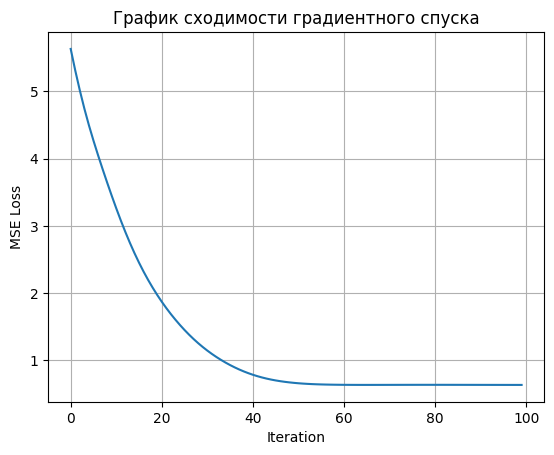

[ 2.08720957  0.83357615  0.22088461 -0.04817688  0.02094772 -0.04864672
 -0.09553682]


In [ ]:
weights, losses = adam(
    X_train, y_train, lr=0.05, n_iter=100,
    calc_loss=True, print_loss=False,
)

plot_history(losses) # визуализация истории обучения
print(weights) # веса

# считаем предсказания на train и test
p_adam_train = predict(X_train, weights)
p_adam_test = predict(X_test, weights)

In [ ]:
# Adam
display(regression_metrics(y_train, p_adam_train))
print()
display(regression_metrics(y_test, p_adam_test))

{'MSE': 0.6358826728021916,
 'RMSE': np.float64(0.7974225183691463),
 'MAE': 0.596570287728555,
 'MAPE': 0.3671786408060531,
 'MSLE': nan,
 'MaxError': np.float64(6.6381952579263945),
 'R²': 0.5243169979925155}

{'MSE': 0.6475615410878719,
 'RMSE': np.float64(0.804712085834351),
 'MAE': 0.6014591565807627,
 'MAPE': 0.3739033025633075,
 'MSLE': 0.06324453758613767,
 'MaxError': np.float64(4.411805980238562),
 'R²': 0.5058324905884253}

## 7. Добавим регуляризацию

Вариация SGD с выбором регуляризации: L1, L2 или Elastic.

In [ ]:
def stochastic_gradient_descent_reg(
    X, y, lr=0.1, n_iter=1000, calc_loss=True, print_loss=False,
    reg_type=None, alpha=0.01, l1_ratio=0.5
):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    losses = []

    for i in range(n_iter):
        # случайный индекс примера
        idx = np.random.randint(0, n_samples)
        x_i = X[idx]
        y_i = y[idx]

        # предсказание
        y_pred = x_i @ weights

        # градиент (по одному примеру)
        error = y_pred - y_i
        grad = 2 * x_i * error

        # добавляем регуляризацию
        if reg_type == 'l2':
            grad += 2 * alpha * weights**2
        elif reg_type == 'l1':
            grad += alpha * np.sign(weights)
        elif reg_type == 'elastic':
            grad += alpha * (l1_ratio * np.sign(weights) +
                             (1 - l1_ratio) * 2 * weights**2)

        # обновление весов
        weights -= lr * grad

        # для отслеживания динамики считаем полный лосс
        if calc_loss:
            y_full_pred = predict(X, weights)
            loss = mse_loss(y, y_full_pred)

            # добавляем регуляризационную часть в лосс
            if reg_type == 'l2':
                loss += alpha * np.sum(weights ** 2)
            elif reg_type == 'l1':
                loss += alpha * np.sum(np.abs(weights))
            elif reg_type == 'elastic':
                loss += alpha * (l1_ratio * np.sum(np.abs(weights)) +
                                 (1 - l1_ratio) * np.sum(weights ** 2))

            losses.append(loss)

            # промежуточные выводы на экран
            if print_loss and i % 10 == 0:
                print(f"Iteration {i}: MSE+Reg = {loss:.4f}")

    return weights, losses

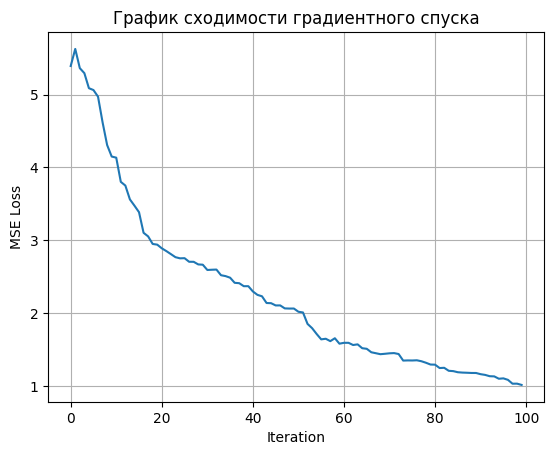

Test MSE: 1.0802


In [ ]:
weights, losses = stochastic_gradient_descent_reg(
    X_train, y_train, lr=0.01, n_iter=100,
    calc_loss=True, print_loss=False, reg_type='l1'
)

plot_history(losses)

y_test_pred = predict(X_test, weights)
test_loss = mse_loss(y_test, y_test_pred)
print(f"Test MSE: {test_loss:.4f}")

## 8. Добавим раннюю остановку

Вариация SGD с возможностью ранней остановки. Но лосс придётся считать чаще:)

In [ ]:
def stochastic_gradient_descent_es(
    X, y, lr=0.1, n_iter=1000, tol=1e-6, patience=10
):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    losses = []

    best_loss = float('inf')
    no_improve_count = 0

    for i in range(n_iter):
        # случайный индекс примера
        idx = np.random.randint(0, n_samples)
        x_i = X[idx]
        y_i = y[idx]

        # предсказание
        y_pred = x_i @ weights

        # градиент (по одному примеру)
        error = y_pred - y_i
        grad = 2 * x_i * error

        # обновление весов
        weights -= lr * grad

        # считаем полный лосс
        y_full_pred = predict(X, weights)
        loss = mse_loss(y, y_full_pred)
        losses.append(loss)

        # проверка на раннюю остановку
        if best_loss - loss > tol:
            best_loss = loss
            no_improve_count = 0
        else:
            no_improve_count += 1

        if no_improve_count >= patience:
            print(f"Early stopping in {i} iter.")
            break

    return weights, losses

Early stopping in 144 iter.


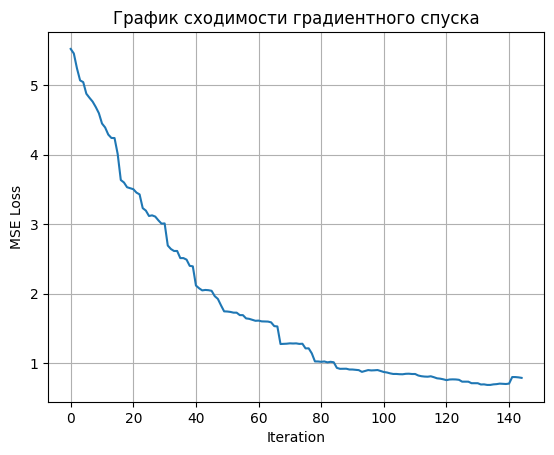

Test MSE: 0.7788


In [ ]:
weights, losses = stochastic_gradient_descent_es(
    X_train, y_train, lr=0.01, n_iter=1000,
)

plot_history(losses)

y_test_pred = predict(X_test, weights)
test_loss = mse_loss(y_test, y_test_pred)
print(f"Test MSE: {test_loss:.4f}")